## Importing Required libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, math
from pathlib import Path

from scipy import stats
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix



## Loading the CTG Dataset

In [ ]:
data = pd.read_csv("CTG.csv")
data.head()

,FileName,Date,SegFile,b,e,LBE,LB,AC,FM,UC,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Variab10.txt,12/1/1996,CTG0001.txt,240.0,357.0,120.0,120.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,2.0
2,Fmcs_1.txt,5/3/1996,CTG0002.txt,5.0,632.0,132.0,132.0,4.0,0.0,4.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
3,Fmcs_1.txt,5/3/1996,CTG0003.txt,177.0,779.0,133.0,133.0,2.0,0.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
4,Fmcs_1.txt,5/3/1996,CTG0004.txt,411.0,1192.0,134.0,134.0,2.0,0.0,6.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0


## Checking for Duplicate Rows

In [103]:
# Check for duplicate rows
duplicates = data[data.duplicated()]
print("Duplicated rows:\n", duplicates)

Duplicated rows:
      FileName Date SegFile   b   e  LBE  LB  AC  FM  UC  ...   C   D   E  AD  \
2127      NaN  NaN     NaN NaN NaN  NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN   

      DE  LD  FS  SUSP  CLASS  NSP  
2127 NaN NaN NaN   NaN    NaN  NaN  

[1 rows x 40 columns]


In [96]:
# Remove duplicate rows, keeping the first occurrence
data_no_duplicates = data.drop_duplicates()

In [97]:
# Save the cleaned dataframe to a new CSV
data.to_csv('cleaned_file.csv', index=False)
print(f"Cleaned data shape: {data.shape}")

Cleaned data shape: (2130, 40)


In [98]:
data.shape

(2130, 40)

## Removing Empty Rows

In [99]:
data.isnull().sum()

FileName    4
Date        4
SegFile     4
b           4
e           4
LBE         4
LB          4
AC          4
FM          3
UC          3
ASTV        3
MSTV        3
ALTV        3
MLTV        3
DL          2
DS          2
DP          2
DR          2
Width       4
Min         4
Max         4
Nmax        4
Nzeros      4
Mode        4
Mean        4
Median      4
Variance    4
Tendency    4
A           4
B           4
C           4
D           4
E           4
AD          4
DE          4
LD          4
FS          4
SUSP        4
CLASS       4
NSP         4
dtype: int64

In [100]:
print("Original dataset shape:", data.shape)
df = data.dropna()
print("After removing rows with missing values:", df.shape)
print("Rows removed:", data.shape[0] - df.shape[0])

Original dataset shape: (2130, 40)
After removing rows with missing values: (2126, 40)
Rows removed: 4


## Remove rows where the duration of data collection is 

If the CTG data is shorter than 10 minutes:

Key signals like decelerations or abnormal variability might be missed, leading to false negatives (failing to identify distress).

Shorter data windows may also increase the likelihood of false positives, where non-distress data is flagged as problematic.

In conclusion, 10 minutes is the minimum recommended time for CTG monitoring to ensure accurate detection of fetal distress and reliable predictions for clinical decision-making. Therefore, we decided to only include data that is collected for at least 10 minutes, so that the model has more reliable data to train on.

In [104]:
# Check if the duration of data collected is less than 10 mins
short_duration_rows = df[(df['e'] - df['b']) < 600]  
print("Rows with duration less than 10 minutes:\n", short_duration_rows)

Rows with duration less than 10 minutes:
             FileName       Date      SegFile       b       e    LBE     LB  \
1       Variab10.txt  12/1/1996  CTG0001.txt   240.0   357.0  120.0  120.0   
24       Mmmfm_1.txt   5/3/1996  CTG0024.txt   510.0   664.0  128.0  128.0   
27       Mmmfm_2.txt   5/3/1996  CTG0027.txt   280.0   477.0  124.0  124.0   
63      S0001081.dat  3/19/1996  CTG0063.txt  1255.0  1557.0  142.0  142.0   
76    S0001089_1.dat   5/2/1996  CTG0076.txt  1341.0  1852.0  154.0  154.0   
...              ...        ...          ...     ...     ...    ...    ...   
2055    S8001041.dsp   6/6/1998  CTG2057.txt  1318.0  1886.0  127.0  127.0   
2112    S8001044.dsp   6/6/1998  CTG2114.txt  1837.0  2297.0  136.0  136.0   
2114    S8001044.dsp   6/6/1998  CTG2116.txt  2252.0  2735.0  136.0  136.0   
2116    S8001045.dsp   6/6/1998  CTG2118.txt     0.0   467.0  140.0  140.0   
2117    S8001045.dsp   6/6/1998  CTG2119.txt   455.0   707.0  140.0  140.0   

       AC   FM   UC  

In [108]:
counts1 = df["NSP"].value_counts()  # Initial dataset
counts2 = short_duration_rows["NSP"].value_counts() # Dataset with duration < 10 mins
counts3 = df["NSP"].value_counts() - short_duration_rows["NSP"].value_counts()   # Cleaned dataset 

print("Original Dataset:\n", counts1)
print("\nDataset removed (less than 10 mins):\n", counts2)

Original Dataset:
 NSP
1.0    1655
2.0     295
3.0     176
Name: count, dtype: int64

Dataset removed (less than 10 mins):
 NSP
1.0    359
2.0     81
3.0     46
Name: count, dtype: int64


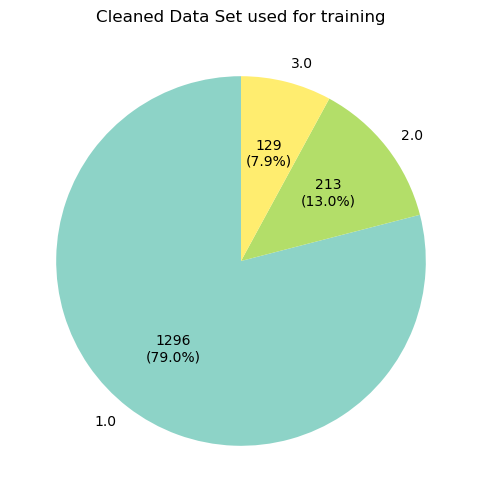

In [111]:
# Plot the pie chart for the cleaned dataset
def func(pct, allvalues):
    absolute = int(pct / 100.*sum(allvalues)) 
    return f"{absolute}\n({pct:.1f}%)"  

plt.figure(figsize=(6, 6))
counts3.plot.pie(autopct=lambda pct: func(pct, counts3), startangle=90, cmap="Set3")
plt.title("Cleaned Data Set used for training")
plt.ylabel("")  
plt.show()

In [77]:
df['duration'] = df['e'] - df['b']
df = df[df['duration'] > 600]
print(df.head())

# Check the shape of the filtered dataframe (number of rows and columns)
print(f"Shape of the dataframe after filtering: {df.shape}")


     FileName      Date      SegFile      b       e    LBE     LB   AC   FM  \
2  Fmcs_1.txt  5/3/1996  CTG0002.txt    5.0   632.0  132.0  132.0  4.0  0.0   
3  Fmcs_1.txt  5/3/1996  CTG0003.txt  177.0   779.0  133.0  133.0  2.0  0.0   
4  Fmcs_1.txt  5/3/1996  CTG0004.txt  411.0  1192.0  134.0  134.0  2.0  0.0   
5  Fmcs_1.txt  5/3/1996  CTG0005.txt  533.0  1147.0  132.0  132.0  4.0  0.0   
6  Fmcs_2.txt  5/3/1996  CTG0006.txt    0.0   953.0  134.0  134.0  1.0  0.0   

     UC  ...    D    E   AD   DE   LD   FS  SUSP  CLASS  NSP  duration  
2   4.0  ...  0.0  0.0  1.0  0.0  0.0  0.0   0.0    6.0  1.0     627.0  
3   5.0  ...  0.0  0.0  1.0  0.0  0.0  0.0   0.0    6.0  1.0     602.0  
4   6.0  ...  0.0  0.0  1.0  0.0  0.0  0.0   0.0    6.0  1.0     781.0  
5   5.0  ...  0.0  0.0  0.0  0.0  0.0  0.0   0.0    2.0  1.0     614.0  
6  10.0  ...  0.0  0.0  0.0  0.0  1.0  0.0   0.0    8.0  3.0     953.0  

[5 rows x 41 columns]
Shape of the dataframe after filtering: (1638, 41)


/var/folders/np/x0ylxxt92tj784qsmkc49w840000gn/T/ipykernel_58002/1254707886.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['duration'] = df['e'] - df['b']


## Understanding the Dataset Better

In [112]:
print(df.groupby('NSP').count())

     FileName  Date  SegFile     b     e   LBE    LB    AC    FM    UC  ...  \
NSP                                                                     ...   
1.0      1655  1655     1655  1655  1655  1655  1655  1655  1655  1655  ...   
2.0       295   295      295   295   295   295   295   295   295   295  ...   
3.0       176   176      176   176   176   176   176   176   176   176  ...   

        B     C     D     E    AD    DE    LD    FS  SUSP  CLASS  
NSP                                                               
1.0  1655  1655  1655  1655  1655  1655  1655  1655  1655   1655  
2.0   295   295   295   295   295   295   295   295   295    295  
3.0   176   176   176   176   176   176   176   176   176    176  

[3 rows x 39 columns]


### Non-essential Columns: 
Based on medical considerations and model training efficiency, drop the following: 
- Non-Numeric Data
- Time Instants in seconds (b, e) 
- LBE --> Used as reference only, not useful for analysis 
- DR  --> Repetitive decelerations, not useful for analysis

In [113]:
drop_cols = ["FileName", "SegFile", "Date", "b", "e", "LBE", "DR", ]
drop_cols = [c for c in drop_cols if c in df.columns]
if drop_cols:
    df = df.drop(columns=drop_cols)
df.columns

Index(['LB', 'AC', 'FM', 'UC', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'DL', 'DS',
       'DP', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean', 'Median',
       'Variance', 'Tendency', 'A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS',
       'SUSP', 'CLASS', 'NSP'],
      dtype='object')

In [114]:
df_without_target = df.drop(columns=['NSP'])
statistics = df_without_target.describe()
transpStat = statistics.transpose()
transpStat = transpStat.drop(['count'], axis =1)

skew = df_without_target.skew()
kurt = df_without_target.kurt()
transpStat['skewness'] = skew
transpStat['kurtosis'] = kurt

transpStat

,mean,std,min,25%,50%,75%,max,skewness,kurtosis
LB,133.303857,9.840844,106.0,126.0,133.0,140.0,160.0,0.020312,-0.292943
AC,2.722484,3.560850,0.0,0.0,1.0,4.0,26.0,1.658830,3.122493
FM,7.241298,37.125309,0.0,0.0,0.0,2.0,564.0,9.427496,104.634368
UC,3.659925,2.847094,0.0,1.0,3.0,5.0,23.0,0.835346,1.289254
ASTV,46.990122,17.192814,12.0,32.0,49.0,61.0,87.0,-0.011829,-1.051030
MSTV,1.332785,0.883241,0.2,0.7,1.2,1.7,7.0,1.657339,4.700756
ALTV,9.846660,18.396880,0.0,0.0,0.0,11.0,91.0,2.195075,4.252998
MLTV,8.187629,5.628247,0.0,4.6,7.4,10.8,50.7,1.331998,4.131254
DL,1.570085,2.499229,0.0,0.0,0.0,3.0,16.0,1.819119,3.146846
DS,0.003293,0.057300,0.0,0.0,0.0,0.0,1.0,17.353457,299.424142


## Visulizing data on a Histogram

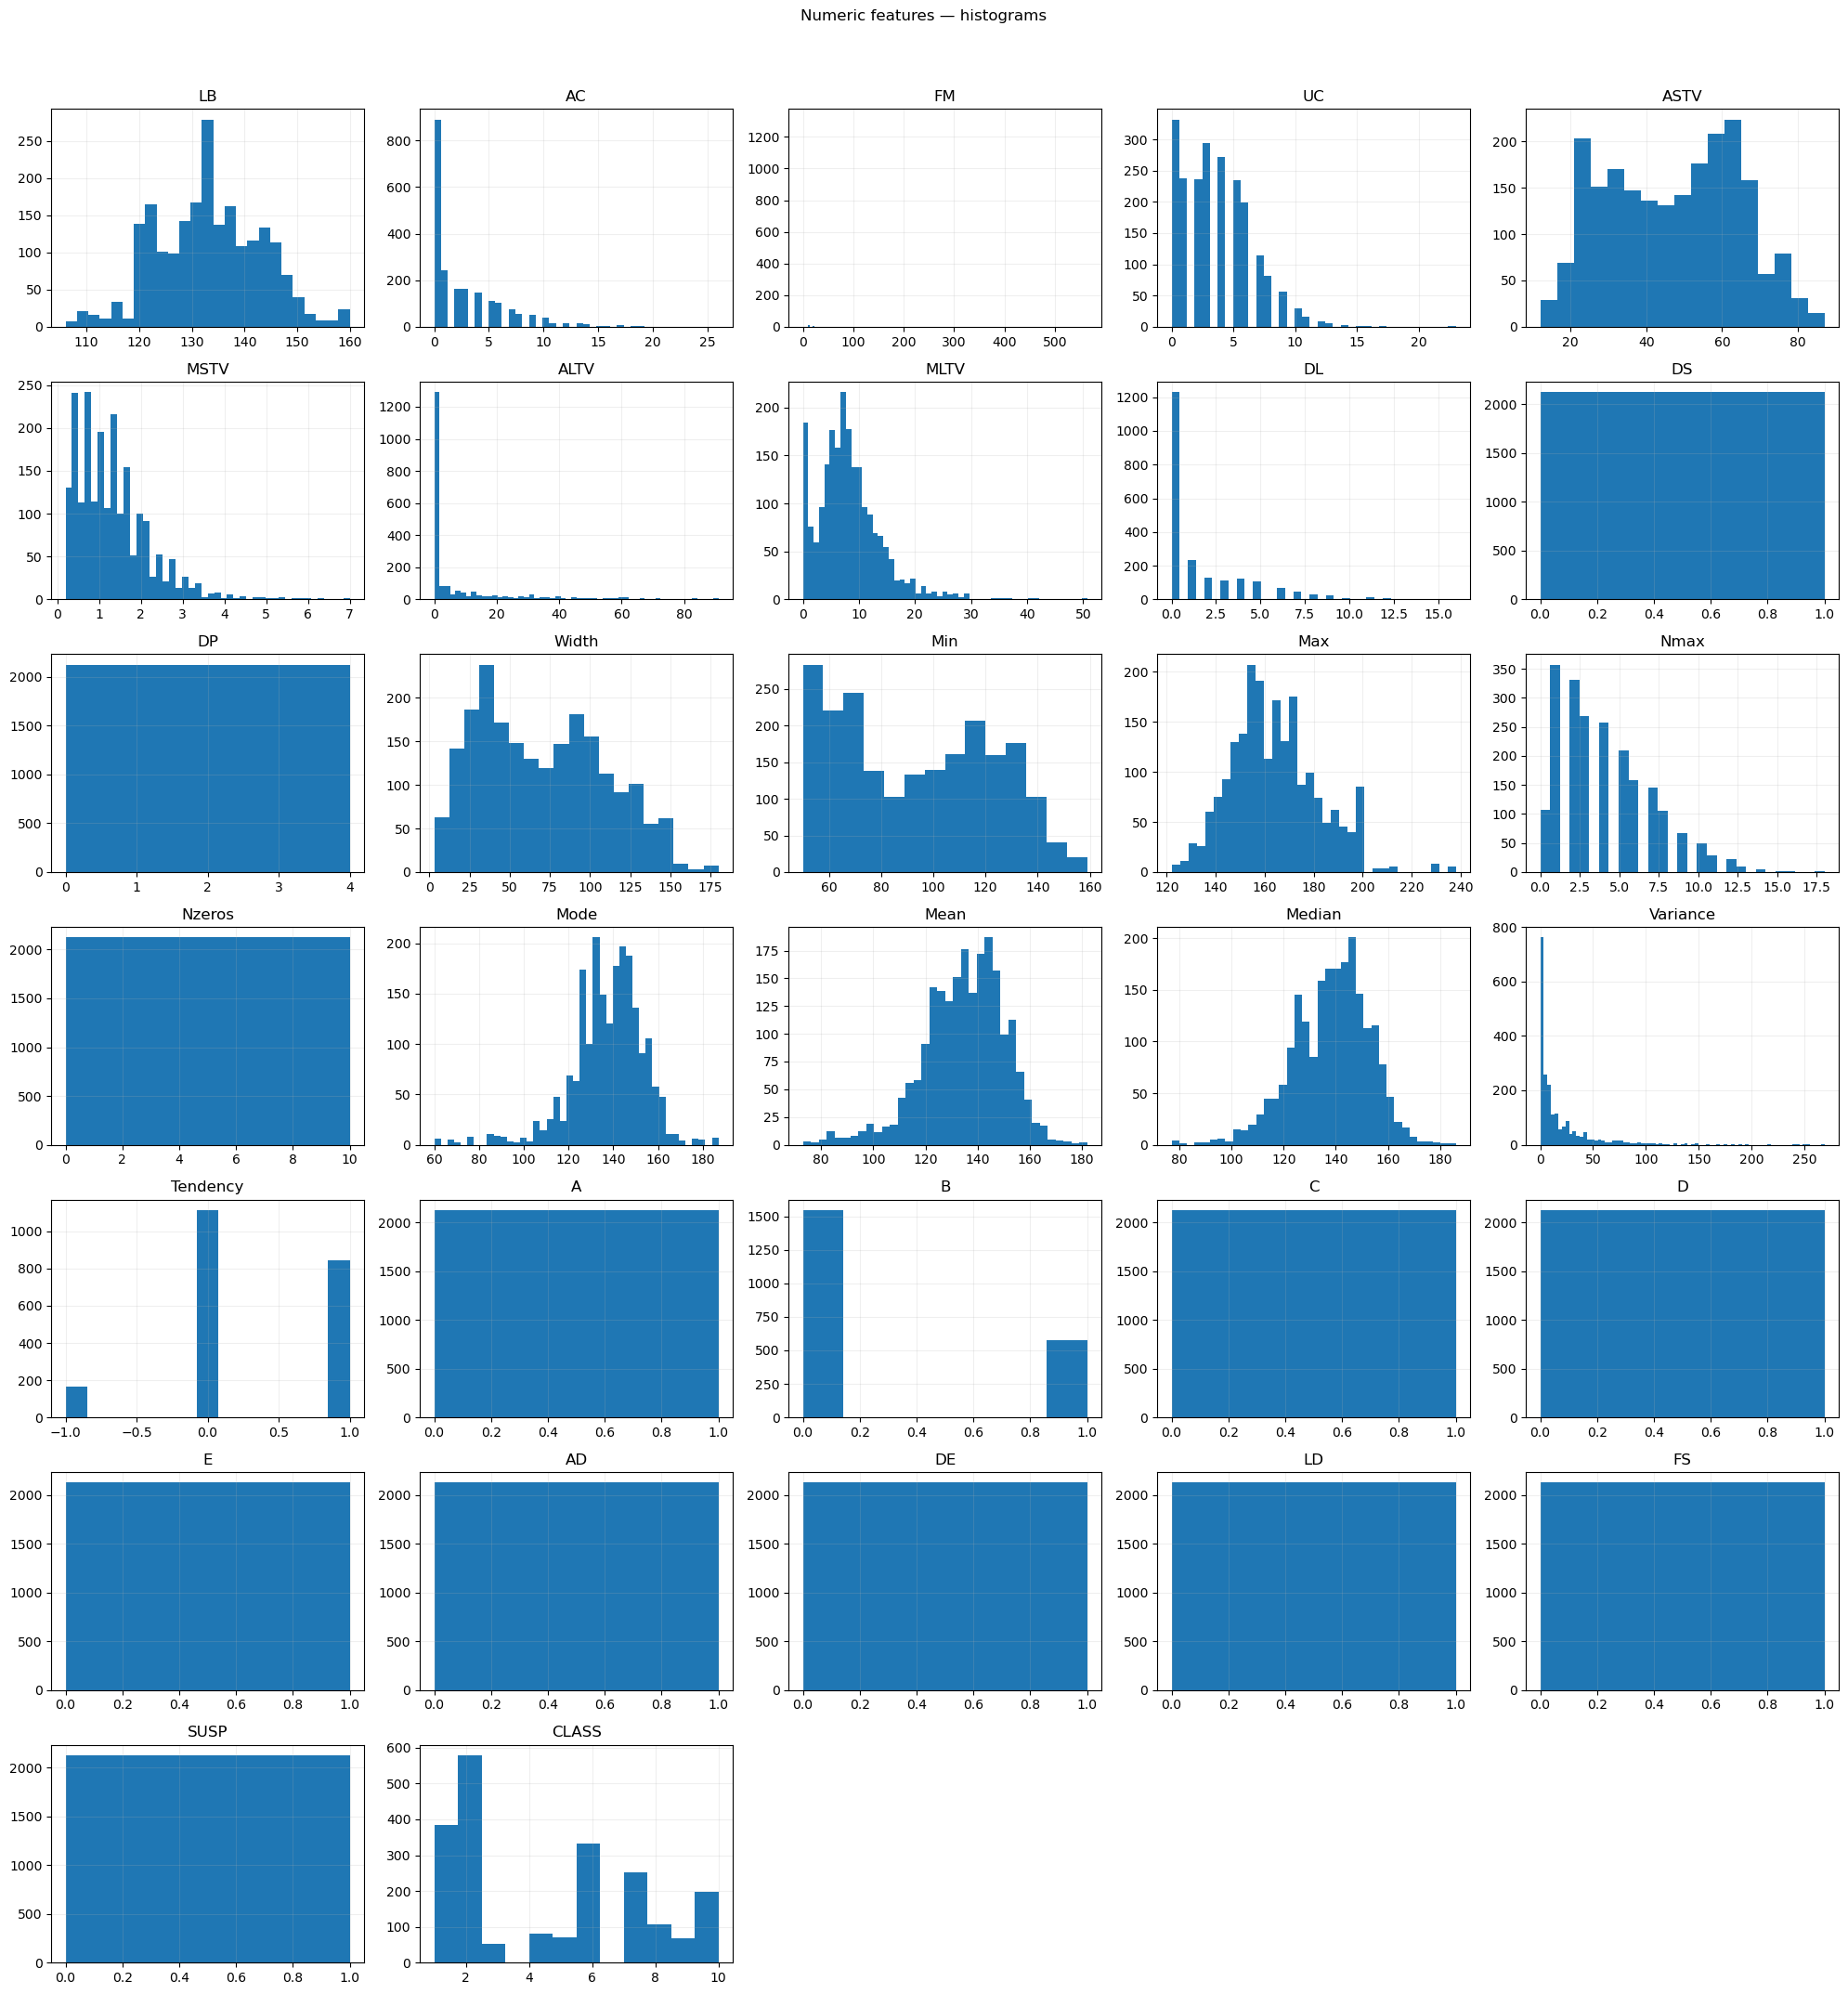

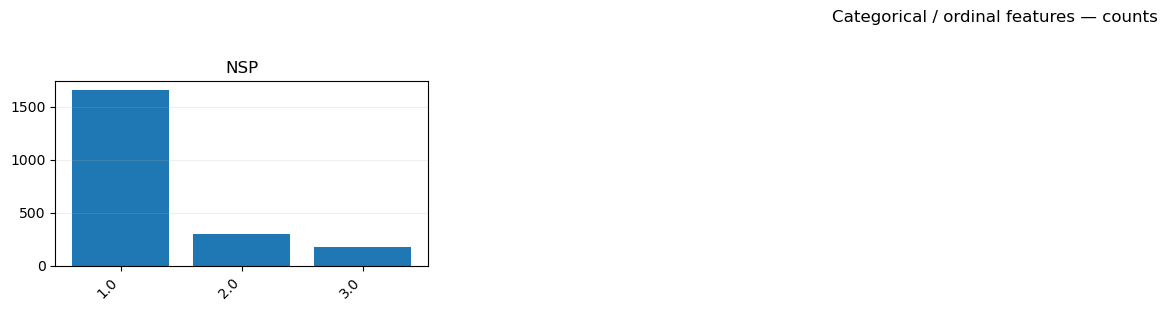

In [116]:
def plot_all_histograms(df: pd.DataFrame, ncols: int = 4, bins: str | int = "fd",
                        exclude: list[str] = None, rotate_xticks: bool = True):

    exclude = exclude or []
    cols = [c for c in df.columns if c not in exclude]

    # Separate by datatype and treat NSP specially
    num_cols = [c for c in cols if pd.api.types.is_numeric_dtype(df[c])]
    cat_cols = [c for c in cols if c not in num_cols]
    if "NSP" in num_cols:  
        num_cols.remove("NSP")
        cat_cols.append("NSP")

    # Histograms for numeric features
    if num_cols:
        n = len(num_cols)
        nrows = math.ceil(n / ncols)
        fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows))
        axes = np.array(axes).reshape(-1)
        for i, col in enumerate(num_cols):
            ax = axes[i]
            data = df[col].dropna()
            ax.hist(data, bins=bins)
            ax.set_title(col)
            ax.grid(alpha=0.2)
        for j in range(i+1, len(axes)): 
            axes[j].set_visible(False)
        fig.suptitle("Numeric features — histograms", y=1.02, fontsize=12)
        fig.tight_layout()
        plt.show()

    # Categorical feature counts
    if cat_cols:
        n = len(cat_cols)
        nrows = math.ceil(n / ncols)
        fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows))
        axes = np.array(axes).reshape(-1)
        for i, col in enumerate(cat_cols):
            ax = axes[i]
            counts = df[col].astype("category").value_counts(dropna=False).sort_index()
            ax.bar([str(x) for x in counts.index], counts.values)
            ax.set_title(col)
            if rotate_xticks:
                for tick in ax.get_xticklabels():
                    tick.set_rotation(45)
                    tick.set_ha("right")
            ax.grid(axis="y", alpha=0.2)
        for j in range(i+1, len(axes)):
            axes[j].set_visible(False)
        fig.suptitle("Categorical / ordinal features — counts", y=1.02, fontsize=12)
        fig.tight_layout()
        plt.show()     
        
plot_all_histograms(df, ncols=5, bins="fd")

## After Histogram Analysis: 

We noticed that more of the columns can be removed because they do not add any value to the training data.  

In [82]:
exclude_cols = ["Min","Max", "NMax", "Nzeros", "CLASS", "SUSP", "FS", "Nmax", "A", "B", "C", "D", "E", "AD", "DE", "LD", "duration"]  # drop any that don’t exist
exclude_cols = [c for c in exclude_cols if c in df.columns]
if exclude_cols:
    df1 = df.drop(columns=exclude_cols)
df1.columns

Index(['LB', 'AC', 'FM', 'UC', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'DL', 'DS',
       'DP', 'Width', 'Mode', 'Mean', 'Median', 'Variance', 'Tendency', 'NSP'],
      dtype='object')

## Understanding the correlation between different features

### Spearman correlation

Spearman works with ranks and is fine for ordinal data.

It checks whether higher NSP values (e.g., going from Normal → Suspicious → Pathological) are associated with increases/decreases in your numerical features.

## Correlation between ASTV/ALTV and Width/Variance


In [117]:
spearman_corr = df1.corr(method="spearman")["NSP"].drop("NSP")
print(spearman_corr)


LB          0.194811
AC         -0.482260
FM          0.053254
UC         -0.214189
ASTV        0.450859
MSTV       -0.244545
ALTV        0.364997
MLTV       -0.169244
DL         -0.031122
DS          0.121449
DP          0.358879
Width      -0.116466
Mode       -0.019963
Mean       -0.004053
Median     -0.022303
Variance   -0.135543
Tendency   -0.064330
Name: NSP, dtype: float64


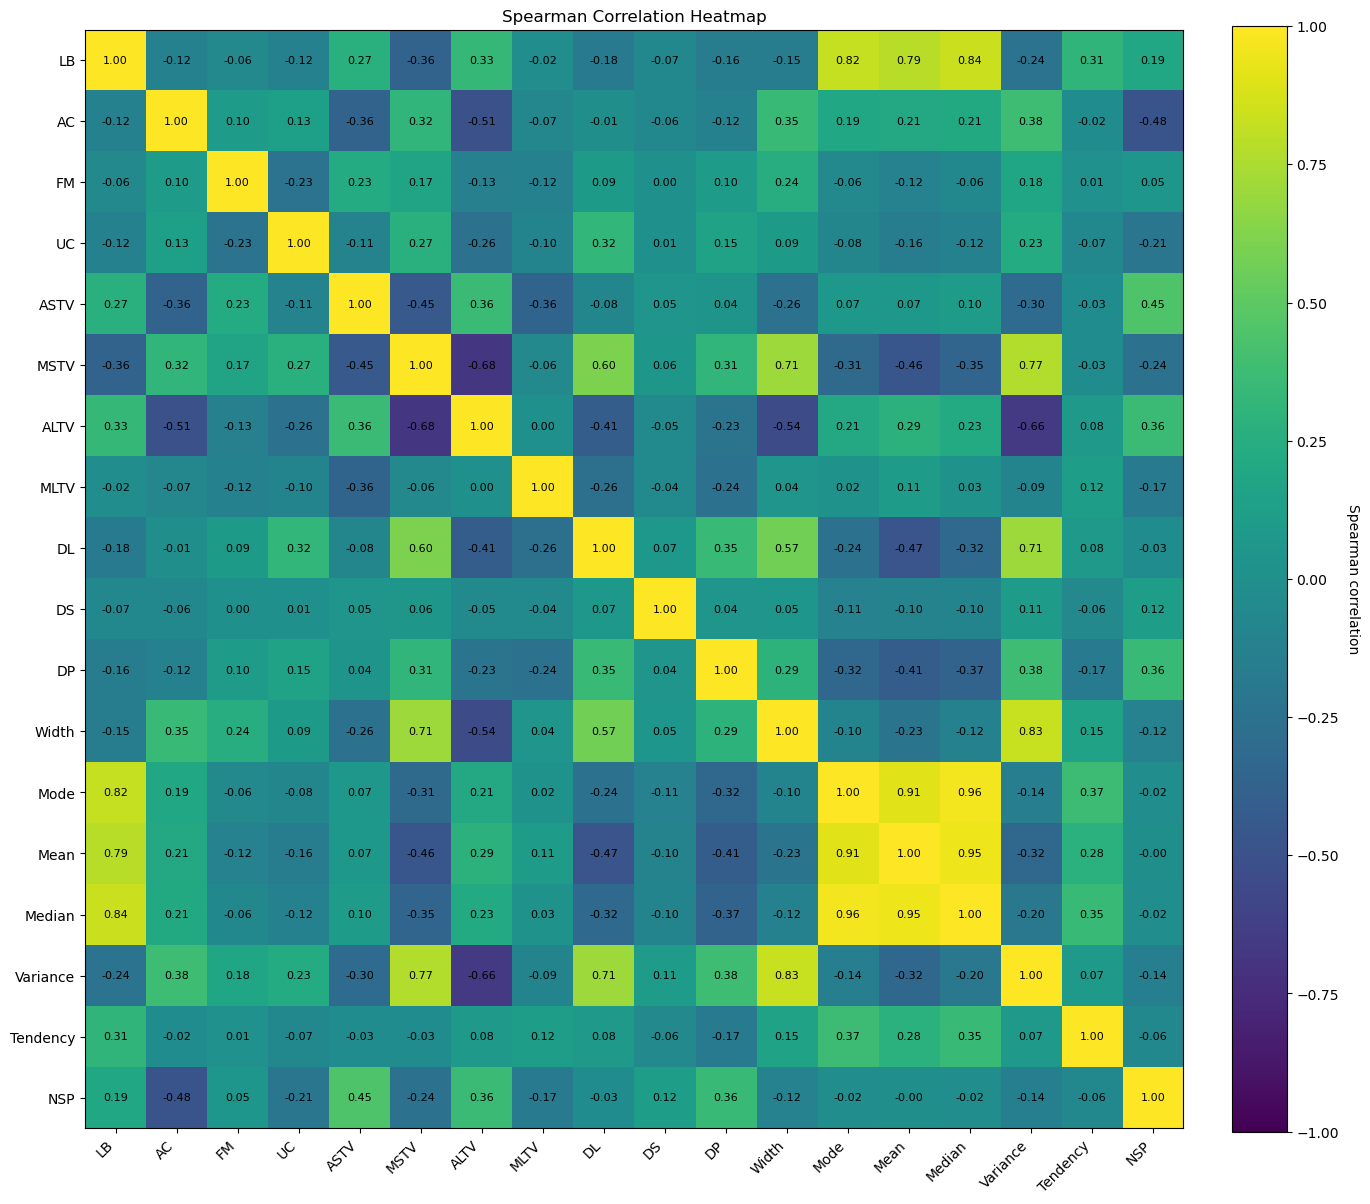

In [119]:
# Keep only numeric columns 
df_num = df1.select_dtypes(include="number")

# Spearman correlation 
corr = df_num.corr(method="spearman")

# Plot heatmap
fig, ax = plt.subplots(figsize=(0.6*len(corr.columns)+3, 0.6*len(corr.columns)+3))
im = ax.imshow(corr.values, vmin=-1, vmax=1)

# Axis ticks & labels
ax.set_xticks(np.arange(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45, ha="right")
ax.set_yticks(np.arange(len(corr.index)))
ax.set_yticklabels(corr.index)

# Colorbar
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Spearman correlation", rotation=270, labelpad=15)

# Display correlation value for each cell
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        ax.text(j, i, f"{corr.iloc[i, j]:.2f}", ha="center", va="center", fontsize=8)

ax.set_title("Spearman Correlation Heatmap")
plt.tight_layout()
plt.show()


In [85]:
df2 = df[["ASTV", "MSTV", "ALTV", "MLTV", "Width", "Variance"]].copy()

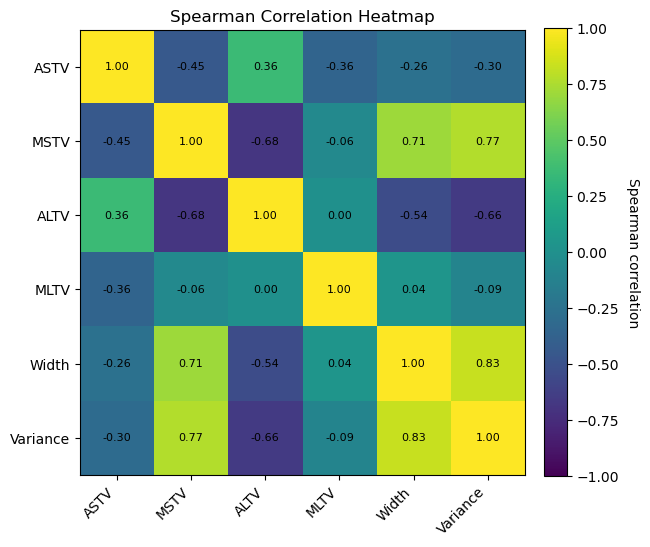

In [121]:
# Keep only numeric columns 
df_num = df2.select_dtypes(include="number")

# Spearman correlation (good for ordinal NSP)
corr = df_num.corr(method="spearman")

#Plot heatmap
fig, ax = plt.subplots(figsize=(0.6*len(corr.columns)+3, 0.6*len(corr.columns)+3))

im = ax.imshow(corr.values, vmin=-1, vmax=1)

# Axis ticks & labels
ax.set_xticks(np.arange(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45, ha="right")
ax.set_yticks(np.arange(len(corr.index)))
ax.set_yticklabels(corr.index)

# Colorbar
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Spearman correlation", rotation=270, labelpad=15)

# Optional: annotate each cell with the correlation value
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        ax.text(j, i, f"{corr.iloc[i, j]:.2f}", ha="center", va="center", fontsize=8)

ax.set_title("Spearman Correlation Heatmap")
plt.tight_layout()
plt.show()
